In [1]:
import pandas as pd
import altair as alt

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
movies_df = pd.read_json('https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json')

# Add a column of the release year
movies_df['Year'] = pd.to_datetime(movies_df['Release_Date']).dt.year
# A list columns that will appear in the final data frame
column_list = ['Title', 'Major_Genre', 'Director', 'Year', 'Worldwide_Gross', 'Production_Budget', 'IMDB_Rating']

# Filter out lines with errors or NaNs in 'Director', 'Year', 'Major_Genre' columns
movies_df = (movies_df.query('Year < 2019')
                     .dropna(subset = column_list)
                     .loc[:, column_list]
                     .reset_index()
                     .drop(columns = ['index']))

In [3]:
movies_df.shape

(1671, 7)

In [4]:
movies_df.describe()

,Year,Worldwide_Gross,Production_Budget,IMDB_Rating
count,1671.000000,1.671000e+03,1.671000e+03,1671.000000
mean,1998.716338,1.254867e+08,4.254949e+07,6.494794
std,9.317537,1.802704e+08,3.968120e+07,1.161293
min,1933.000000,0.000000e+00,7.000000e+03,1.700000
25%,1996.000000,2.067742e+07,1.500000e+07,5.800000
50%,2001.000000,6.125970e+07,3.000000e+07,6.600000
75%,2005.000000,1.633916e+08,6.000000e+07,7.300000
max,2010.000000,2.767891e+09,3.000000e+08,9.200000


In [5]:
movies_df.to_csv('../data/clean/movies_clean_df.csv')

In [6]:
def mds_special():
    font = "Arial"
    axisColor = "#000000"
    gridColor = "#DEDDDD"
    return {
        "config": {
            "title": {
                "fontSize": 24,
                "font": font,
                "anchor": "start", # equivalent of left-aligned.
                "fontColor": "#000000"
            },
            'view': {
                "height": 300, 
                "width": 400
            },
            "axisX": {
                "domain": True,
                #"domainColor": axisColor,
                "gridColor": gridColor,
                "domainWidth": 1,
                "grid": False,
                "labelFont": font,
                "labelFontSize": 12,
                "labelAngle": 0, 
                "tickColor": axisColor,
                "tickSize": 5, # default, including it just to show you can change it
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "X Axis Title (units)", 
            },
            "axisY": {
                "domain": False,
                "grid": True,
                "gridColor": gridColor,
                "gridWidth": 1,
                "labelFont": font,
                "labelFontSize": 14,
                "labelAngle": 0, 
                #"ticks": False, # even if you don't have a "domain" you need to turn these off.
                "titleFont": font,
                "titleFontSize": 16,
                "titlePadding": 10, # guessing, not specified in styleguide
                "title": "Y Axis Title (units)", 
                # titles are by default vertical left of axis so we need to hack this 
                #"titleAngle": 0, # horizontal
                #"titleY": -10, # move it up
                #"titleX": 18, # move it to the right so it aligns with the labels 
            },
        }
    }

In [7]:
def get_top_director(selected_df, num, genre):
    """
    Finds the number of movies of the most productive directors in the selected genre

    Parameters
    ----------
    movies_df: pandas.DataFrame
        The data frame to work on
    num: int
        The number of directors to keep in each genre
    genre: string
        The selected genre

    Returns
    -------
    pandas.DataFrame
        The data frame contains the number of movies of the most productive directors in the selected genre
    """

    mdfg = selected_df.groupby('Major_Genre')
    return (mdfg.get_group(genre)
                .groupby('Director')
                .count()
                .sort_values(by = 'Title', ascending = False)
                .head(num)
                .reset_index()
                .iloc[:, :2]
                .rename(columns = {'Title': 'Count'}))

In [8]:
def get_top_df(selected_df, num, genre):
    """
    Finds movie information from the most productive directors in the selected genre

    Parameters
    ----------
    movies_df: pandas.DataFrame
        The data frame to work on
    num: int
        The number of directors to keep in each genre
    genre: string
        The selected genre

    Returns
    -------
    pandas.DataFrame
        The data frame only contains movie information from the most productive directors in the selected genre
    """

    
    top_director = get_top_director(selected_df, num, genre)
    top_director['Major_Genre'] = genre
    return pd.merge(selected_df, 
                    top_director, 
                    how = "inner", 
                    on = ['Major_Genre', 'Director'])

In [9]:
get_top_df(movies_df, 30, 'Action')

,Title,Major_Genre,Director,Year,Worldwide_Gross,Production_Budget,IMDB_Rating,Count
0,The Abyss,Action,James Cameron,1989,54243125.0,70000000.0,7.6,6
1,Aliens,Action,James Cameron,1986,183316455.0,17000000.0,7.5,6
2,True Lies,Action,James Cameron,1994,365300000.0,100000000.0,7.2,6
3,Terminator 2: Judgment Day,Action,James Cameron,1991,516816151.0,100000000.0,8.5,6
4,The Terminator,Action,James Cameron,1984,78019031.0,6400000.0,8.1,6
...,...,...,...,...,...,...,...,...
118,The Matrix Revolutions,Action,Andy Wachowski,2003,424259759.0,110000000.0,6.5,4
119,Speed Racer,Action,Andy Wachowski,2008,93394462.0,120000000.0,6.3,4
120,Surrogates,Action,Jonathan Mostow,2009,119668350.0,80000000.0,6.3,3
121,Terminator 3: Rise of the Machines,Action,Jonathan Mostow,2003,433058296.0,170000000.0,6.6,3


In [10]:
def make_bar_plot(genre = 'Action', year = (1933, 2010)):
    # Don't forget to include imports
    
    # register the custom theme under a chosen name
    alt.themes.register('mds_special', mds_special)

    # enable the newly registered theme
    alt.themes.enable('mds_special')
    #alt.themes.enable('none') # to return to default
    
    # get the clean movies data
    movies_df = pd.read_csv('../data/clean/movies_clean_df.csv', index_col = 0)
    # get information from the 30 most productive directors in the selected genre
    selected_df = movies_df[(movies_df['Year'] > year[0]) & (movies_df['Year'] < year[1])]
    top_director = get_top_director(selected_df, 30, genre)
    
    # Create a bar graph of the 30 most productive directors in the selected genre
    return alt.Chart(top_director).encode(
                alt.Y('Director:N', title = 'Director'),
                alt.X('Count:Q', title = 'Number of movies')
            ).mark_bar().properties(
                title = 'Top 30 productive directors in ' + genre,
                width = 300, 
                height = 350).interactive()

In [11]:
def make_scatter_plot(genre = 'Action', year = (1933, 2010)):
    # Don't forget to include imports
    
    # register the custom theme under a chosen name
    alt.themes.register('mds_special', mds_special)

    # enable the newly registered theme
    alt.themes.enable('mds_special')
    #alt.themes.enable('none') # to return to default
    
    # get the clean movies data
    movies_df = pd.read_csv('../data/clean/movies_clean_df.csv', index_col = 0)
    # get information from the 30 most productive directors in the selected genre
    selected_df = movies_df[(movies_df['Year'] > year[0]) & (movies_df['Year'] < year[1])]
    top_df = get_top_df(selected_df, 30, genre)
    
    # Create scatter plots of rating and profits


    return chart

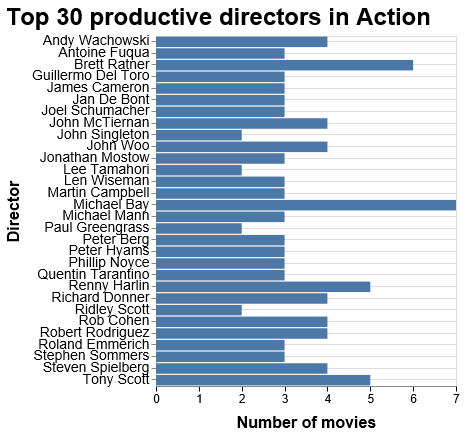

In [12]:
make_bar_plot(genre = 'Action', year = (1990, 2010))

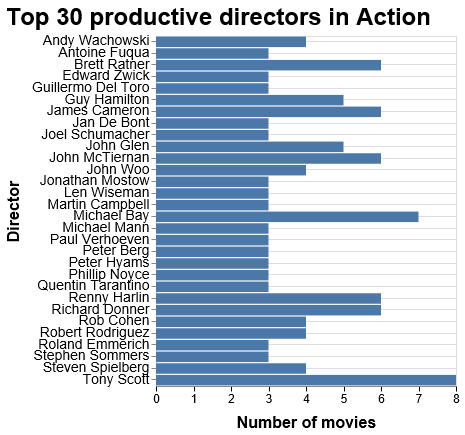

In [13]:
make_bar_plot()